In [1]:
! pip install statsmodels

You should consider upgrading via the 'c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('pruebillas.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:
import numpy as np
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from backbone.probability_transformer import ProbabilityTransformer 
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from backbone.utils import load_function
from typing import Tuple
import yaml
from sklearn.metrics import classification_report
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from tqdm import tqdm
from statsmodels.tsa.filters.hp_filter import hpfilter
import os
from sklearn.metrics import accuracy_score

pd.options.display.max_rows = 999

In [3]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

def apply_cusum_filter(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

# Función para calcular la volatilidad diaria
def get_daily_volatility(close_prices, span=100):
    returns = close_prices.pct_change()
    volatility = returns.ewm(span=span).std()
    return volatility

def apply_triple_barrier(
    close_prices, 
    max_prices, 
    min_prices, 
    take_profit_in_pips, 
    stop_loss_in_pips, 
    side,
    max_holding_period=50, 
    pip_size=0.0001
    ):

    barriers = []
    for index in range(len(close_prices)):
        actual_close_price = close_prices[index]
        
        if side[index] == 1:
            # Para una señal de compra
            upper_barrier_level = round(actual_close_price + (take_profit_in_pips * pip_size), 4)
            lower_barrier_level = round(actual_close_price - (stop_loss_in_pips * pip_size), 4)
        elif side[index] == -1:
            # Para una señal de venta
            upper_barrier_level = round(actual_close_price + (stop_loss_in_pips * pip_size), 4)
            lower_barrier_level = round(actual_close_price - (take_profit_in_pips * pip_size), 4)
        else:
            # Si no hay señal, saltar al siguiente índice
            continue
        
        # Evaluar los precios futuros dentro del período máximo de mantenimiento
        for j in range(index + 1, min(index + max_holding_period, len(close_prices))):
            future_close_price = close_prices[j]
            future_max_price = max_prices[j]
            future_min_price = min_prices[j]
            
            if side[index] == 1:

                # Señal de compra: tomar ganancias si se alcanza la barrera superior
                if (future_close_price < upper_barrier_level) and (future_close_price > lower_barrier_level) and (future_max_price >= upper_barrier_level) and (future_min_price <= lower_barrier_level):
                    result = random.choice([(index, 0), (index,1)])
                    barriers.append(result)
                    break

                if future_close_price >= upper_barrier_level or future_max_price >= upper_barrier_level:
                    barriers.append((index, 1))  # Etiqueta 1 para toma de ganancias
                    break

                elif future_close_price <= lower_barrier_level or future_min_price <= lower_barrier_level:
                    barriers.append((index, 0))  # Etiqueta 0 para stop-loss
                    break

            elif side[index] == -1:

                if (future_close_price < upper_barrier_level) and (future_close_price > lower_barrier_level) and (future_min_price <= lower_barrier_level) and (future_max_price >= upper_barrier_level):
                    result = random.choice([(index, 0), (index,1)])
                    barriers.append(result)
                    break

                # Señal de venta: tomar ganancias si se alcanza la barrera inferior
                if future_close_price <= lower_barrier_level or future_min_price <= lower_barrier_level:
                    barriers.append((index, 1))  # Etiqueta 1 para toma de ganancias
                    break

                elif future_close_price >= upper_barrier_level or future_max_price >= upper_barrier_level:
                    barriers.append((index, 0))  # Etiqueta 0 para stop-loss
                    break
        else:
            barriers.append((index, 2))  # Etiqueta 2 si no se alcanza ninguna barrera
    
    # Revisar los eventos etiquetados como 2 para determinar si son ganancias o pérdidas
    for idx, (event_index, label) in enumerate(barriers):
        if label == 2:
            # Determinar si el precio final fue una ganancia o una pérdida
            final_price = close_prices[min(event_index + max_holding_period, len(close_prices) - 1)]
            initial_price = close_prices[event_index]
            
            if side[event_index] == 1:
                # Para una señal de compra
                if final_price >= initial_price:
                    barriers[idx] = (event_index, 1)  # Etiqueta 1 para toma de ganancias
                elif final_price < initial_price:
                    barriers[idx] = (event_index, 0)  # Etiqueta 0 para stop-loss
            elif side[event_index] == -1:
                # Para una señal de venta
                if final_price <= initial_price:
                    barriers[idx] = (event_index, 1)  # Etiqueta 1 para toma de ganancias
                elif final_price > initial_price:
                    barriers[idx] = (event_index, 0)  # Etiqueta 0 para stop-loss

    return barriers



def triple_barrier_labeling(
        close_prices, 
        max_prices, 
        min_prices,  
        take_profit_in_pips, 
        stop_loss_in_pips, 
        side,
        max_holding_period=50, 
        pip_size=0.0001,
    ):

    labels = apply_triple_barrier(
        close_prices,
        max_prices,
        min_prices,
        take_profit_in_pips, 
        stop_loss_in_pips, 
        side,
        max_holding_period, 
        pip_size
    )
    
    target = [label for _, label in labels]
    return target

def bbands(close_prices, window, no_of_stdev):
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [4]:
def __apply_hpfilter(window, window_size, lamb):
  if len(window) < window_size:
      return np.nan  # Devuelve NaN si la ventana no está completa

  _, trend = hpfilter(window, lamb=lamb)
  return trend[-1]

In [5]:
symbols_path = './backbone/data/backtest/symbols/XAUUSD.csv'
df = pd.read_csv(symbols_path)
df = df[['Date','Close','High','Low','Open', 'upper_bband','lower_bband','macdhist','rsi', 'adx','mfi', 'ema_flag']]
print('Creando target')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df = df.set_index('Date')

instrument = df.copy()
# compute bband sides

df['trend'] = np.nan
lamb = 5000
window_size = 300
apply_hpfilter_with_params = lambda window: __apply_hpfilter(window, window_size, lamb)
instrument['trend'] = instrument['Close'].rolling(window=window_size).apply(apply_hpfilter_with_params, raw=True)

instrument['SMA20'] = instrument['trend'].rolling(window=20).mean()

instrument['side'] = np.nan

instrument['hp_flag'] = 0
instrument['hp_flag'] = np.where((instrument['trend'] > instrument['SMA20']) & (instrument['trend'].shift(1) <= instrument['SMA20'].shift(1)), 1, instrument['hp_flag'])
instrument['hp_flag'] = np.where((instrument['trend'] < instrument['SMA20']) & (instrument['trend'].shift(1) >= instrument['SMA20'].shift(1)), -1, instrument['hp_flag'])

instrument['macd_flag'] = 0
instrument['macd_flag'] = np.where((instrument['macdhist'].shift(1) < 0) & (instrument['macdhist'] > 0), 1, instrument['macd_flag'])
instrument['macd_flag'] = np.where((instrument['macdhist'].shift(1) > 0) & (instrument['macdhist'] < 0), -1, instrument['macd_flag'])

instrument['bband_flag'] = 0
instrument['bband_flag'] = np.where((df['Close'] > instrument['upper_bband']), 1, instrument['bband_flag']) 
instrument['bband_flag'] = np.where((df['Close'] < instrument['lower_bband']), -1, instrument['bband_flag']) 

instrument['rsi_flag'] = 0
instrument['rsi_flag'] = np.where((instrument['rsi'] > 70), -1, instrument['rsi_flag'])
instrument['rsi_flag'] = np.where((instrument['rsi'] < 30), 1, instrument['rsi_flag'])

instrument['adx_flag'] = 0
instrument['adx_flag'] = np.where((instrument['adx'] > 25), 1, instrument['adx_flag'])

instrument['mfi_flag'] = 0
instrument['mfi_flag'] = np.where((instrument['mfi'] > 80), -1, instrument['mfi_flag'])
instrument['mfi_flag'] = np.where((instrument['mfi'] < 20), 1, instrument['mfi_flag'])

window = 5
instrument['macd_flag_positive_window'] = instrument['macd_flag'].rolling(window=window).apply(lambda x: 1 if (x == 1).any() else 0, raw=True)
instrument['bband_flag_positive_window'] = instrument['bband_flag'].rolling(window=window).apply(lambda x: 1 if (x == 1).any() else 0, raw=True)
instrument['rsi_flag_positive_window'] = instrument['rsi_flag'].rolling(window=window).apply(lambda x: 1 if (x == 1).any() else 0, raw=True) 
instrument['hp_flag_positive_window'] = instrument['hp_flag'].rolling(window=window).apply(lambda x: 1 if (x == 1).any() else 0, raw=True) 
instrument['ema_flag_positive_window'] = instrument['ema_flag'].rolling(window=window).apply(lambda x: 1 if (x == 1).any() else 0, raw=True) 

instrument['mfi_flag_positive_window'] = instrument['mfi_flag'].rolling(window=window).apply(lambda x: 1 if (x == 1).any() else 0, raw=True) 

instrument['adx_flag_window'] = instrument['adx_flag'].rolling(window=window).apply(lambda x: 1 if (x == 1).any() else 0, raw=True) 

instrument['macd_flag_negative_window'] = instrument['macd_flag'].rolling(window=window).apply(lambda x: 1 if (x == -1).any() else 0, raw=True)
instrument['bband_flag_negative_window'] = instrument['bband_flag'].rolling(window=window).apply(lambda x: 1 if (x == -1).any() else 0, raw=True)
instrument['rsi_flag_negative_window'] = instrument['rsi_flag'].rolling(window=window).apply(lambda x: 1 if (x == -1).any() else 0, raw=True)
instrument['hp_flag_negative_window'] = instrument['hp_flag'].rolling(window=window).apply(lambda x: 1 if (x == -1).any() else 0, raw=True)
instrument['mfi_flag_negative_window'] = instrument['mfi_flag'].rolling(window=window).apply(lambda x: 1 if (x == -1).any() else 0, raw=True)
instrument['ema_flag_negative_window'] = instrument['ema_flag'].rolling(window=window).apply(lambda x: 1 if (x == -1).any() else 0, raw=True)


# Esto deberia estar parametrizado
amount_conditions = 2
long_signals = (
  # (instrument['macd_flag_positive_window'] == 1).astype(int) +
  # (instrument['bband_flag_positive_window'] == 1).astype(int) +
  # (instrument['rsi_flag_positive_window'] == 1).astype(int) +
  (instrument['hp_flag_positive_window'] == 1).astype(int) +
  # (instrument['ema_flag_positive_window'] == 1).astype(int) +
  # (instrument['mfi_flag_positive_window'] == 1).astype(int) +
  (instrument['adx_flag_window'] == 1).astype(int)
) >= amount_conditions

short_signals = (
  # (instrument['macd_flag_negative_window'] == 1).astype(int) +
  # (instrument['bband_flag_negative_window'] == 1).astype(int) +
  # (instrument['rsi_flag_negative_window'] == 1).astype(int) +
  (instrument['hp_flag_negative_window'] == 1).astype(int) +
  # (instrument['ema_flag_negative_window'] == 1).astype(int) +
  # (instrument['mfi_flag_negative_window'] == 1).astype(int) +
  (instrument['adx_flag_window'] == 1).astype(int)
) >= amount_conditions

instrument.loc[long_signals, 'side'] = 1
instrument.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
# instrument['side'] = instrument['side'].shift(1)


instrument.dropna(inplace=True)




Creando target


In [6]:
sl = 25
rr = 3
holding_period = 8

instrument['target'] = triple_barrier_labeling(
    close_prices=instrument['Close'], 
    max_prices=instrument['High'], 
    min_prices=instrument['Low'], 
    stop_loss_in_pips=sl, 
    take_profit_in_pips=sl * rr, 
    max_holding_period=holding_period, 
    pip_size=0.001,
    side=instrument['side']
)

print('side', instrument.side.value_counts())
print('-----------------------------------------------')
print('target', instrument.target.value_counts())
print('-----------------------------------------------')
instrument['dummy_model_pred'] = 1
acc = accuracy_score(instrument[instrument.side != 0].target, instrument[instrument.side != 0].dummy_model_pred)
print(acc)

side side
-1.0    515
 1.0    475
Name: count, dtype: int64
-----------------------------------------------
target target
1    834
0    156
Name: count, dtype: int64
-----------------------------------------------
0.8424242424242424


In [7]:
print(classification_report(instrument[instrument.side != 0].target, instrument[instrument.side != 0].dummy_model_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       156
           1       0.84      1.00      0.91       834

    accuracy                           0.84       990
   macro avg       0.42      0.50      0.46       990
weighted avg       0.71      0.84      0.77       990



c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [8]:
df.loc[instrument.index, 'side'] = instrument.side
df.loc[instrument.index, 'target'] = instrument.target
df.fillna(0, inplace=True)
df.reset_index(inplace=True)

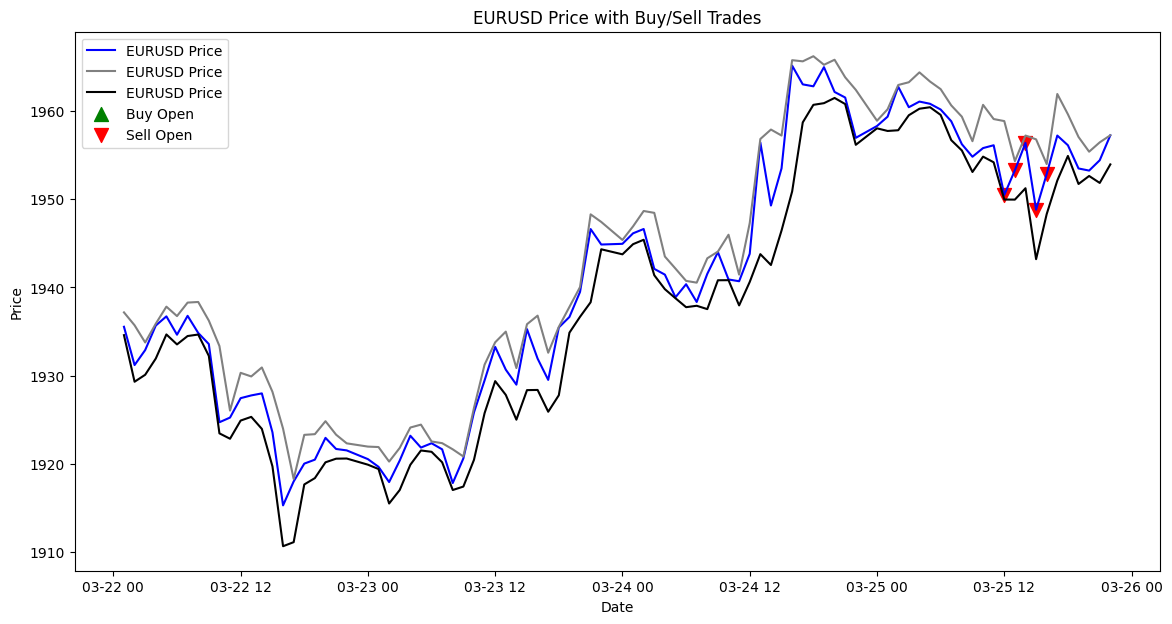

2022-03-22 2022-03-27


KeyboardInterrupt: Interrupted by user

In [9]:
import matplotlib.pyplot as plt 
from IPython.display import clear_output


ticker = 'EURUSD'
date_from = datetime(2022,1,1)
date_to = date_from + timedelta(days=5)

while date_to < datetime(2024,1,1):
    date_from_str = date_from.strftime('%Y-%m-%d')
    date_to_str = date_to.strftime('%Y-%m-%d')

    historical_prices = df
    
    historical_prices = historical_prices[
        (historical_prices['Date']>date_from_str)
        & (historical_prices['Date']<date_to_str)
    ]
    
    plt.figure(figsize=(14, 7))
    plt.plot(historical_prices['Date'], historical_prices['Close'], label=f'{ticker} Price', color='blue')
    plt.plot(historical_prices['Date'], historical_prices['High'], label=f'{ticker} Price', color='gray')
    plt.plot(historical_prices['Date'], historical_prices['Low'], label=f'{ticker} Price', color='black')
    
    # Añadir las operaciones de compra y venta
    buy_trades = df[
        (df['side']==1) 
        & (df['target']==1)
        & (df['Date']>date_from_str)
        & (df['Date']<date_to_str)
    ]
    sell_trades = df[
        (df['side']==-1) 
        & (df['target']==1)
        & (df['Date']>date_from_str)
        & (df['Date']<date_to_str)
    ]
    
    # Graficar las operaciones de compra
    plt.scatter(buy_trades['Date'], buy_trades['Close'], color='green', marker='^', s=100, label='Buy Open')
    
    # Graficar las operaciones de venta
    plt.scatter(sell_trades['Date'], sell_trades['Close'], color='red', marker='v', s=100, label='Sell Open')
    
    # Añadir etiquetas y leyenda
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} Price with Buy/Sell Trades')
    plt.legend()
    
    # Mostrar el gráfico
    plt.show()
    
    print(date_from_str, date_to_str)
   
    a = input()
    
    clear_output(wait=True)

    date_from += timedelta(days=5)
    date_to = date_from + timedelta(days=5)


In [30]:
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df['hour'] = df.Date.dt.hour

df[df.side!=0].groupby(['year','month','day'])['side'].count()



year  month  day
2021  10     11      2
             12      1
             13      3
             19      3
             20      3
             22      4
             25      5
             28      3
      11     2       2
             4       5
             5       1
             12      1
             25      3
      12     13      6
             16      3
             20      3
             28      2
2022  1      3       6
             4       3
             10      3
             11      3
             12      7
             19      1
             21      6
             27      6
      2      8       9
             9       3
             10      3
             11      3
             18      3
             24      2
             25      1
             28      3
      3      7       3
             10      3
             11      3
             15      3
             18      1
             21      1
             25     10
             29      6
             30      3
      4      11  

# Accuracy

0.5652173913043478

In [13]:
instrument[(instrument.side != 0) & (instrument.target==1)].shape[0] / instrument[(instrument.side!=0)].shape[0]

0.5652173913043478

In [14]:
df.groupby(['year', 'month', 'side'])['side'].count()

year  month  side
2021  9       0.0    209
      10     -1.0      1
              0.0    503
      11     -1.0      3
              0.0    524
      12      0.0    546
              1.0      3
2022  1      -1.0      1
              0.0    503
      2       0.0    478
              1.0      2
      3       0.0    550
      4      -1.0      3
              0.0    501
      5       0.0    528
      6       0.0    528
      7       0.0    504
      8       0.0    552
      9      -1.0      3
              0.0    521
              1.0      4
      10      0.0    504
      11      0.0    520
              1.0      7
      12      0.0    519
2023  1       0.0    518
              1.0      3
      2       0.0    480
      3      -1.0      5
              0.0    544
              1.0      1
      4       0.0    480
      5      -1.0      2
              0.0    550
      6       0.0    528
      7      -1.0      4
              0.0    499
      8       0.0    552
      9      -1.0      4
       

In [22]:
df = pd.read_csv('./backbone/data/trading/symbols/dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month

df.groupby(['year', 'month', 'side'])['side'].count()

year  month  side
2023  3      -1.0      23
              0.0    1628
              1.0      23
      4      -1.0      35
              0.0    2808
              1.0      37
      5      -1.0      46
              0.0    3221
              1.0      45
      6      -1.0      41
              0.0    3086
              1.0      41
      7      -1.0      37
              0.0    2944
              1.0      37
      8      -1.0      43
              0.0    3228
              1.0      41
      9      -1.0      40
              0.0    2942
              1.0      42
      10     -1.0      36
              0.0    3096
              1.0      36
      11     -1.0      37
              0.0    3089
              1.0      36
      12     -1.0      39
              0.0    2819
              1.0      39
2024  1      -1.0      51
              0.0    3067
              1.0      50
      2      -1.0      51
              0.0    2921
              1.0      52
      3      -1.0      38
              0.0   

In [23]:
df['dummy_model_pred'] = 1
accuracy_score(df[df.side != 0].target, df[df.side != 0].dummy_model_pred)

0.7106676899462778

In [24]:
print(classification_report(df[df.side != 0].target, df[df.side != 0].dummy_model_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       377
         1.0       0.71      1.00      0.83       926

    accuracy                           0.71      1303
   macro avg       0.36      0.50      0.42      1303
weighted avg       0.51      0.71      0.59      1303



c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [25]:
df[df.side != 0].side.value_counts()

side
 1.0    653
-1.0    650
Name: count, dtype: int64

In [26]:
df[df.side != 0].target.value_counts()

target
1.0    926
0.0    377
Name: count, dtype: int64

In [8]:
# import pandas as pd
# import os
# pd.set_option('display.max_columns', None)

# periods_forward = 5

# tickers = ['EURUSD']
# symbols_path = './backbone/data/backtest/symbols'
# instruments = {}
# df = pd.DataFrame()

# for ticker in tickers:
#     instruments[ticker] = pd.read_csv(os.path.join(symbols_path, f'{ticker}.csv'))
  
#     instruments[ticker]['ticker'] = ticker
  
#     print('Creando target')
   
#     instruments[ticker] = instruments[ticker].sort_values(by='Date')

#     instruments[ticker]['target'] = triple_barrier_labeling(instruments[ticker], upper_barrier=0.015, lower_barrier=0.015, max_holding_period=48, span=100)
    
#     df = pd.concat([
#         df,
#         instruments[ticker]
#     ])

#     df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:00:00')

#     df = df.sort_values(by='Date')

In [205]:
df = pd.read_csv('./backbone/data/backtest/symbols/dataset.csv')

In [206]:
df.adx

0        45.511529
1        48.282765
2        39.093260
3        30.782478
4        33.047150
           ...    
85344    15.097938
85345    17.517605
85346    21.824213
85347    19.882942
85348    28.458146
Name: adx, Length: 85349, dtype: float64

In [3]:
date_format = '%Y-%m-%d %H:00:00'
window = 11520

actual_date = datetime(2024,5,1,0,0,0)

date_to = actual_date - timedelta(hours=24+1) 
date_from = date_to - timedelta(hours=window)

date_from_test = actual_date
date_to_test = date_from_test + timedelta(hours=1440)

date_from_str = date_from.strftime(date_format)
date_to_str = date_to.strftime(date_format)
date_from_test_str = date_from_test.strftime(date_format)
date_to_test_str = date_to_test.strftime(date_format)


train = df[(df['Date']>date_from_str) & (df['Date']<date_to_str) & (df.side != 0)]
test = df[(df['Date']>date_from_test_str) & (df['Date']<date_to_test_str) & (df.side != 0)]

# Inicio undersampling
# class_0 = train[train['target']==0]
# class_2 = train[train['target']==2]
# avg_examples = (class_0.shape[0] + class_2.shape[0]) / 2
# class_1 = train[train['target']==1].tail(int(avg_examples)).sample(frac=1)

# train = pd.concat([class_0, class_1, class_2])
# fin undersampling

train.target.value_counts()

target
1.0    911
0.0    410
Name: count, dtype: int64

In [4]:
test.target.value_counts()

target
1.0    109
0.0     51
Name: count, dtype: int64

In [5]:
from backbone.machine_learning_agent import MachineLearningAgent

with open('./configs/model_config.yml', 'r') as file:
    model_configs = yaml.safe_load(file)

cols_to_drop = [
  'Open',
  'High',
  'Low',
  'Close',
  'target', 
  'Date', 
  'ticker'
]

model_name = 'gradient_boosting'

param_grid = model_configs[model_name]['param_grid']
model = model_configs[model_name]['model']

mla = MachineLearningAgent(
    tickers=['EURUSD', 'GBPUSD', 'USDJPY', 'USDCAD', 'AUDUSD', 'USDCHF'], 
    model=model, 
    param_grid=param_grid
)

In [6]:
x_train = train.drop(columns=cols_to_drop)
y_train = train.target

In [7]:
y_train.value_counts()

target
1.0    911
0.0    410
Name: count, dtype: int64

In [8]:
mla.train(
    x_train = train.drop(columns=cols_to_drop),
    x_test = test.drop(columns=cols_to_drop),
    y_train = train.target,
    y_test = test.target,
    date_train=actual_date,
    verbose=True,
    undersampling=False
)

Best parameter (CV score=0.666):
Best params: {'stacking__prob_transf__model__learning_rate': 0.05, 'stacking__prob_transf__model__max_depth': 3, 'stacking__prob_transf__model__n_estimators': 15, 'stacking__prob_transf__model__objective': 'binary:logistic', 'stacking__prob_transf__model__random_state': 42}
train precision:  0.7202983061799935
train recall:  0.6207418622255867
train f1:  0.6335370336600004


# Train performance

In [9]:
classes, probas = mla.predict_proba(train.drop(columns=cols_to_drop))

precision = precision_score(train.target, classes, average='weighted')
recall = recall_score(train.target, classes, average='weighted')
f1 = f1_score(train.target, classes, average='weighted')

print(precision)
print(recall)
print(f1) 

# target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(train.target, classes))

0.7202983061799935
0.6207418622255867
0.6335370336600004
              precision    recall  f1-score   support

         0.0       0.44      0.78      0.56       410
         1.0       0.85      0.55      0.67       911

    accuracy                           0.62      1321
   macro avg       0.64      0.66      0.61      1321
weighted avg       0.72      0.62      0.63      1321



# Test performance

In [10]:
classes, probas = mla.predict_proba(test.drop(columns=cols_to_drop))

precision = precision_score(test.target, classes, average='weighted')
recall = recall_score(test.target, classes, average='weighted')
f1 = f1_score(test.target, classes, average='weighted')

print(precision)
print(recall)
print(f1) 

# target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test.target, classes))

0.69697265625
0.58125
0.5908826825527899
              precision    recall  f1-score   support

         0.0       0.42      0.78      0.54        51
         1.0       0.83      0.49      0.61       109

    accuracy                           0.58       160
   macro avg       0.62      0.64      0.58       160
weighted avg       0.70      0.58      0.59       160



In [45]:
binary_probas = np.where(classes == 0, 1-probas, probas)
binary_probas

array([0.56022815, 0.55082354, 0.50557515, 0.55082354, 0.52867405,
       0.55082354, 0.4059493 , 0.61017602, 0.4557834 , 0.52179368,
       0.4557834 , 0.51165662, 0.4557834 , 0.46706189, 0.4557834 ,
       0.44505992, 0.49837506, 0.49837506, 0.52179368, 0.54430971,
       0.50237604, 0.4557834 , 0.51165662, 0.49837506, 0.4557834 ,
       0.49837506, 0.49837506, 0.49837506, 0.46706189, 0.44721178,
       0.44721178, 0.46706189, 0.4557834 , 0.54430971, 0.49837506,
       0.47711913, 0.59232572, 0.49837506, 0.47711913, 0.47711913,
       0.49837506, 0.52179368, 0.4557834 ])

In [88]:
test['pred_label'] = np.nan
test['proba'] = np.nan

cols_to_drop += ['pred_label', 'proba']
side = (test.side != 0).any()

for index, stock in test.iterrows():
  
  if side:
      # Drop the specified columns before prediction
      stock_features = stock.drop(labels=cols_to_drop)
      
      stock_features_df = pd.DataFrame([stock_features])

      # Predict the class and probability
      _class, proba = mla.predict_proba(stock_features_df)
      
      # Assign the predicted class and probability to the DataFrame
      test.at[index, 'pred_label'] = _class
      test.at[index, 'proba'] = proba


C:\Users\SaidJ\AppData\Local\Temp\ipykernel_1672\669063084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_label'] = np.nan
C:\Users\SaidJ\AppData\Local\Temp\ipykernel_1672\669063084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['proba'] = np.nan


In [90]:
precision = precision_score(test.target, test.pred_label, average='weighted')
recall = recall_score(test.target, test.pred_label, average='weighted')
f1 = f1_score(test.target, test.pred_label, average='weighted')

print(precision)
print(recall)
print(f1) 

# target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test.target, test.pred_label))

0.733634797588286
0.5813953488372093
0.5909504550050556
              precision    recall  f1-score   support

         0.0       0.41      0.85      0.55        13
         1.0       0.88      0.47      0.61        30

    accuracy                           0.58        43
   macro avg       0.64      0.66      0.58        43
weighted avg       0.73      0.58      0.59        43



In [74]:
test_results = {}
test_results['EURUSD'] = {}
test_results['USDJPY'] = {}
test_results['USDCAD'] = {}
test_results['EURUSD']['2021-01-01']={}
test_results['USDJPY']['2021-01-01']={}
test_results['USDCAD']['2021-01-01']={}

test_results['EURUSD']['2021-01-02']={}
test_results['USDJPY']['2021-01-02']={}
test_results['USDCAD']['2021-01-02']={}

In [75]:
test_results['EURUSD']['2021-01-01']['y_true'] = 1
test_results['EURUSD']['2021-01-01']['y_pred'] = 0
test_results['EURUSD']['2021-01-01']['y_proba'] = 0.2

test_results['USDJPY']['2021-01-01']['y_true'] = 1
test_results['USDJPY']['2021-01-01']['y_pred'] = 0
test_results['USDJPY']['2021-01-01']['y_proba'] = 0.2

test_results['USDCAD']['2021-01-01']['y_true'] = 1
test_results['USDCAD']['2021-01-01']['y_pred'] = 0
test_results['USDCAD']['2021-01-01']['y_proba'] = 0.2

test_results['EURUSD']['2021-01-02']['y_true'] = 1
test_results['EURUSD']['2021-01-02']['y_pred'] = 0
test_results['EURUSD']['2021-01-02']['y_proba'] = 0.2

test_results['USDJPY']['2021-01-02']['y_true'] = 1
test_results['USDJPY']['2021-01-02']['y_pred'] = 0
test_results['USDJPY']['2021-01-02']['y_proba'] = 0.2

test_results['USDCAD']['2021-01-02']['y_true'] = 1
test_results['USDCAD']['2021-01-02']['y_pred'] = 0
test_results['USDCAD']['2021-01-02']['y_proba'] = 0.2

In [76]:
test_results

{'EURUSD': {'2021-01-01': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2},
  '2021-01-02': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2}},
 'USDJPY': {'2021-01-01': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2},
  '2021-01-02': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2}},
 'USDCAD': {'2021-01-01': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2},
  '2021-01-02': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2}}}

In [77]:
df_results = pd.DataFrame()

for ticker, values in test_results.items():
    for date, values2 in values.items():
        single_line_df = pd.DataFrame(
            {
                'ticker':[ticker], 
                'date':[date], 
                'y_true':values2['y_true'], 
                'y_pred':values2['y_pred'], 
                'proba':values2['y_proba'],
            }
        )

        df_results = pd.concat([df_results, single_line_df])

df_results
           

,ticker,date,y_true,y_pred,proba
0,EURUSD,2021-01-01,1,0,0.2
0,EURUSD,2021-01-02,1,0,0.2
0,USDJPY,2021-01-01,1,0,0.2
0,USDJPY,2021-01-02,1,0,0.2
0,USDCAD,2021-01-01,1,0,0.2
0,USDCAD,2021-01-02,1,0,0.2


In [61]:
df

EURUSD  y_pred   2021-01-01    0.0
        y_proba  2021-01-01    0.2
        y_true   2021-01-01    1.0
USDJPY  y_pred   2021-01-01    0.0
        y_proba  2021-01-01    0.2
        y_true   2021-01-01    1.0
USDCAD  y_pred   2021-01-01    0.0
        y_proba  2021-01-01    0.2
        y_true   2021-01-01    1.0
dtype: float64

USDCAD


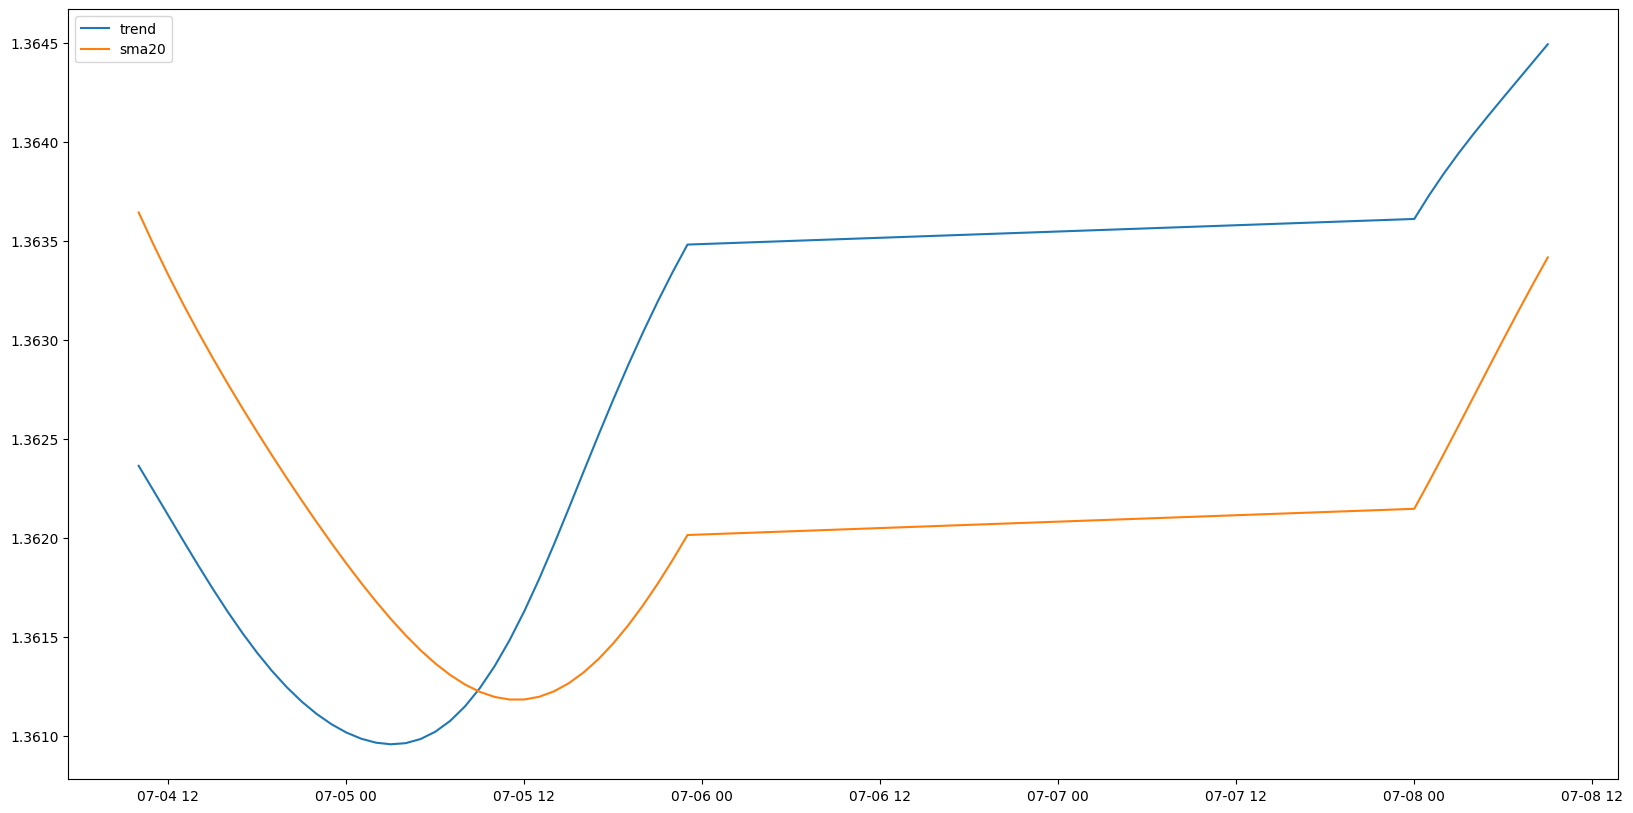

In [22]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

df = pd.read_csv('./backbone/data/trading/symbols/dataset.csv')


for ticker in df.ticker.unique():
    print(ticker)
    df_ticker = df[df['ticker']==ticker].tail(48)
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Datos de ejemplo
    x = pd.to_datetime(df_ticker['Date'])
    trend = df_ticker['trend']  # Datos para la línea
    sma20 = df_ticker['SMA20']  # Datos para la línea
    
    # Crear una figura y ejes
    
    # Agregar la línea
    ax.plot(x, trend, label='trend')
    ax.plot(x, sma20, label='sma20')
        
    ax.legend()
        
        # Mostrar el gráfico
        # print(path)
    plt.show()
    a = input()
    
    clear_output(wait=True)

In [24]:
df[(df['side']!=0)].tail()[['Date','ticker','side']]

,Date,ticker,side
48414,2024-07-03 00:00:00,EURUSD,1.0
48451,2024-07-03 06:00:00,USDCHF,-1.0
48517,2024-07-03 17:00:00,USDJPY,-1.0
48758,2024-07-05 09:00:00,USDCAD,1.0
48886,2024-07-08 06:00:00,EURUSD,-1.0


In [15]:
df[(df['side']!=0)].tail()[['Date','ticker','side']]

,Date,ticker,side
48498,2024-07-03 17:00:00,USDJPY,-1.0
48742,2024-07-05 09:00:00,USDCAD,1.0
48882,2024-07-08 09:00:00,USDJPY,1.0
48899,2024-07-08 12:00:00,AUDUSD,-1.0
48913,2024-07-08 14:00:00,USDCAD,-1.0


In [ ]:
df.side.